In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Churn_Modelling.csv")

# Data Cleaning & Exploration

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No missing values

In [5]:
df.duplicated().sum()

0

No duplicate rows

## Dropping irrelevant columns

Irrelevant variables for analysis are:
- RowNumber
- CustomerId
- Surname

In [6]:
irrelevant_rows = ["RowNumber", "CustomerId", "Surname"]
df.drop(columns=irrelevant_rows, inplace = True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df.shape

(10000, 11)

10,000 observations in the sample, data for 11 different variables

Our main variable of interest is **Exited**: Label indicating whether or not a customer has churned from the bank

# Descriptive Statistics

## Continuous Variables
- Credit Score
- Age
- Tenure (may double as a categorical variable)
- Balance
- Number of Products (may double as a categorical variable)
- Estimated Salary

In [8]:
continuous_variables = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
print("Mean observations for continuous variables:") 
print(df.describe().loc['mean',continuous_variables])
print("\n")
print("Median observations for continuous variables:")
print(df.describe().loc['50%',continuous_variables])

Mean observations for continuous variables:
CreditScore           650.528800
Age                    38.921800
Tenure                  5.012800
Balance             76485.889288
NumOfProducts           1.530200
EstimatedSalary    100090.239881
Name: mean, dtype: float64


Median observations for continuous variables:
CreditScore           652.000
Age                    37.000
Tenure                  5.000
Balance             97198.540
NumOfProducts           1.000
EstimatedSalary    100193.915
Name: 50%, dtype: float64


*(For money-related data, we can assume that the currency is *euros*, since the three geographical regions of the bank customers in this sample are France, Germany, and Spain, and no currency is specified in the description for the dataset)*

In [10]:
for variable in continuous_variables:
    print(f"LQ and UQ for {variable} are: ", df.describe().loc["25%",variable], " and ", df.describe().loc["75%",variable])

LQ and UQ for CreditScore are:  584.0  and  718.0
LQ and UQ for Age are:  32.0  and  44.0
LQ and UQ for Tenure are:  3.0  and  7.0
LQ and UQ for Balance are:  0.0  and  127644.24
LQ and UQ for NumOfProducts are:  1.0  and  2.0
LQ and UQ for EstimatedSalary are:  51002.11  and  149388.2475


In [11]:
print("Standard deviations for continuous variables:")
print(df.describe().loc['std',continuous_variables])

Standard deviations for continuous variables:
CreditScore           96.653299
Age                   10.487806
Tenure                 2.892174
Balance            62397.405202
NumOfProducts          0.581654
EstimatedSalary    57510.492818
Name: std, dtype: float64


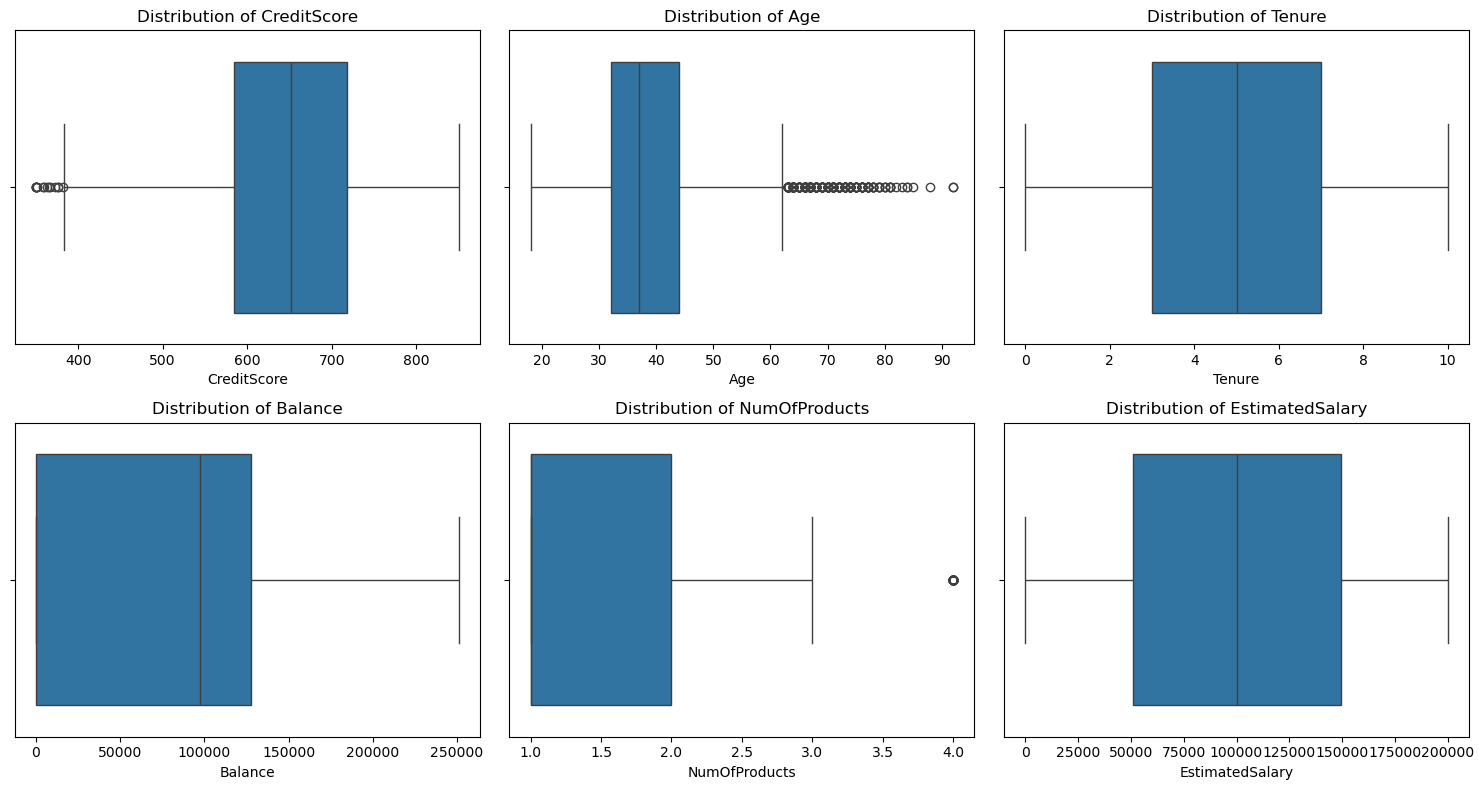

In [12]:
fig, axes = plt.subplots(2,3,figsize=(15,8))
axes = axes.flatten()

for i, variable in enumerate(continuous_variables):
    sns.boxplot(x=variable, data=df, ax=axes[i])
    title = f"Distribution of {variable}" 
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

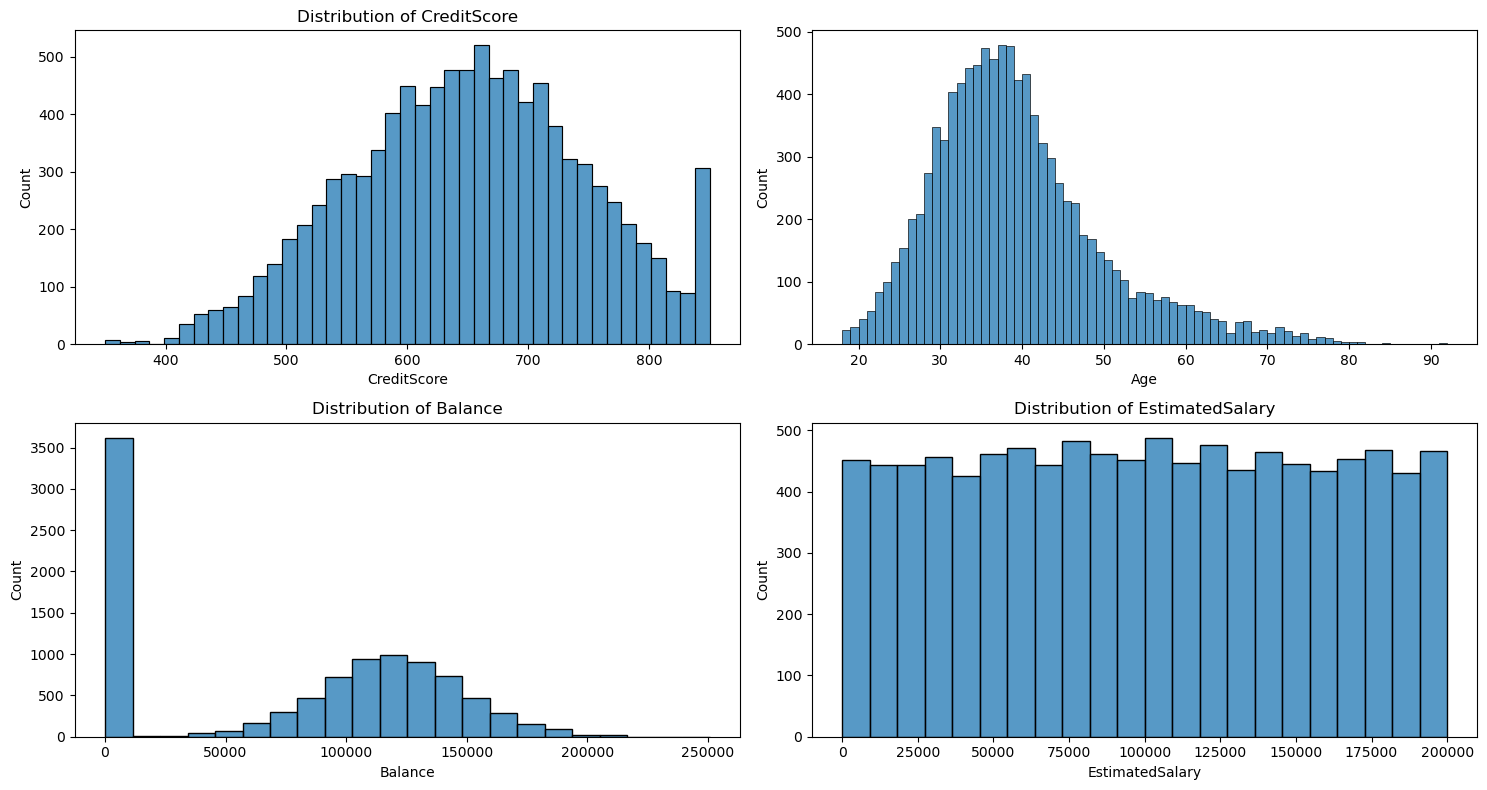

In [13]:
fig, axes = plt.subplots(2,2,figsize=(15,8))
axes = axes.flatten()

hist_variables = ["CreditScore", "Age", "Balance", "EstimatedSalary"]

for i, variable in enumerate(hist_variables):
    if variable == "Age":
        sns.histplot(x=variable, data=df, ax=axes[i], bins = 92-18)
    else:
        sns.histplot(x=variable, data=df, ax=axes[i])
        title = f"Distribution of {variable}" 
        axes[i].set_title(title)

plt.tight_layout()
plt.show()

**Comments**:
- *Credit Score*: appears to approximately normally distributed, although there are several customers who appear to have achieved the max credit score (850) explaining why there is a tall bar right at the end
- *Age*: Right-skewed with many older customers, although not large in quantity, compared to the median: 37 years old
- *Balance*: Appears normally distributed but a huge number of accounts with a balance of 0 has affected the shape of the graph (another visualization without these empty accounts is shown below)
- *Estimated Salary*: Appears approximately uniformly distributed from €11.58 (minimum) to €199,992.48 (maximum)

In [14]:
print("Number of Customers with a 850 credit score: ", df[df['CreditScore'] > 849].shape[0])

Number of Customers with a 850 credit score:  233


<Axes: xlabel='Balance', ylabel='Count'>

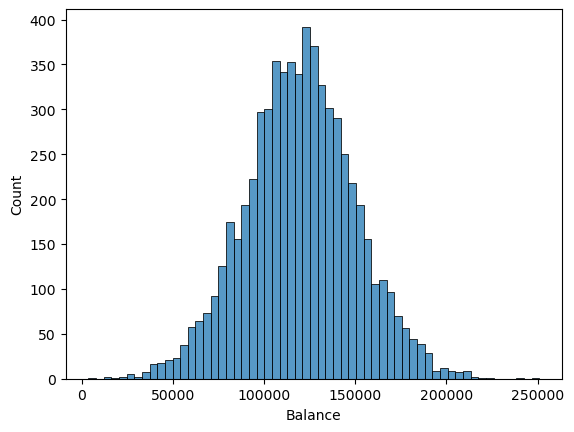

In [15]:
sns.histplot(x='Balance', data=df[df["Balance"] > 0])

## Categorical Variables
- Geography
- Gender
- Tenure (may double as a continuous variable)
- Number of Products (may double as a continuous variable)
- 'Has Credit Card'
- 'Is Active Member'
- Exited (Churned)

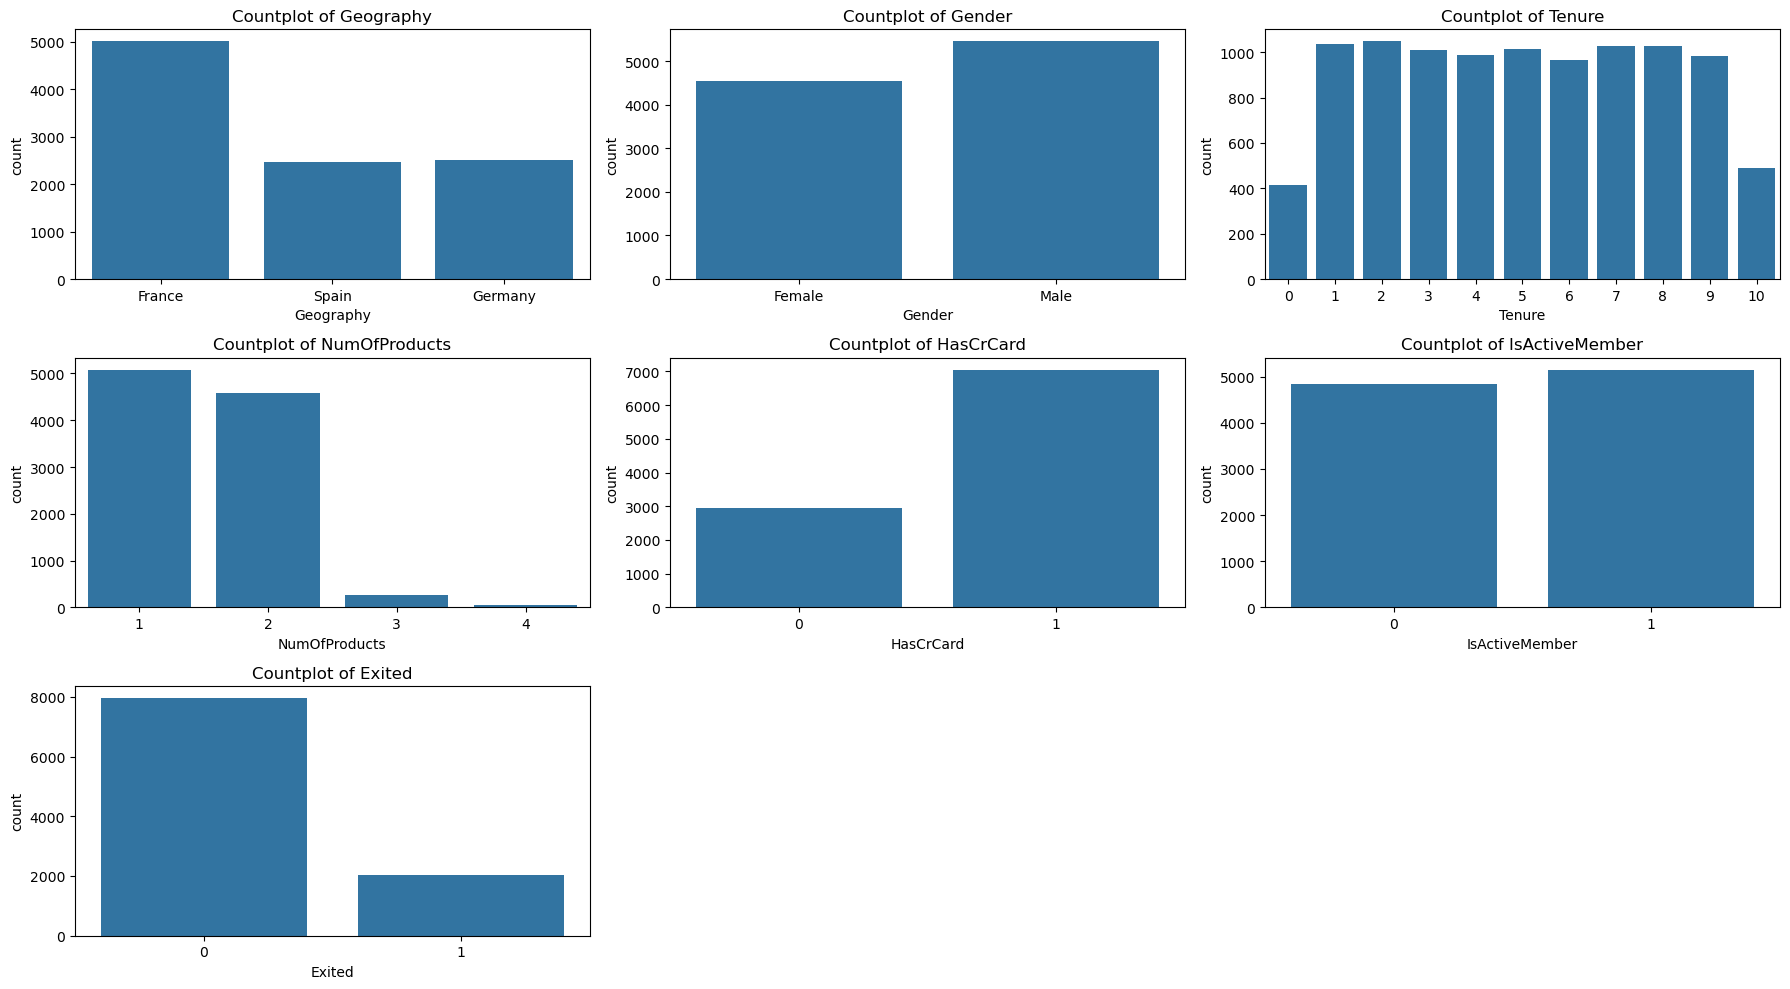

In [16]:
fig, axes = plt.subplots(3,3,figsize=(18,10))
axes = axes.flatten()

categorical_variables = ["Geography", "Gender", "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember", "Exited"]
for i, variable in enumerate(categorical_variables):
    sns.countplot(x=variable, data=df, ax=axes[i])
    title = f"Countplot of {variable}" 
    axes[i].set_title(title)

axes[7].axis("off")
axes[8].axis("off")
plt.tight_layout()
plt.show()

**Comments**:
- *Geography:* Around half of the customers in the sample are based in France, and the remaining customers are almost evenly split between Spain and Germany
- *Gender:* The Female/Male split in the sample is approximately 45/55 (i.e. there are around 1000 more Males than Females)
- *Tenure:* The number of years customers stay with the bank is very variable (distribution seems uniform, with the exception of few people staying for either <1 year or 10+ years)
- *Number of Products:* The vast majority of customers in this sample have either 1 or 2 products with the bank (very few have 3 or 4)
- *'Has a Credit Card':* The majoriy (~70%) of customers have a credit card with the bank, and the remaining customers do not
- *'Is an Active Member':* The sample contains an almost equal amount of active/inactive members
- *Exited:* As previously mentioned,, the churn rate in the sample is ~20%

# Research Objectives

## 1. Customer Profiling
> **What does the average bank customer look like?**

In [17]:
df.describe().iloc[1,]

CreditScore           650.528800
Age                    38.921800
Tenure                  5.012800
Balance             76485.889288
NumOfProducts           1.530200
HasCrCard               0.705500
IsActiveMember          0.515100
EstimatedSalary    100090.239881
Exited                  0.203700
Name: mean, dtype: float64

In [18]:
df_churners = df[df["Exited"] == 1]
df_non_churners = df[df["Exited"] == 0]

In [19]:
print("Number of churners: ", df_churners.shape[0])
print("Number of non-churners: ", df_non_churners.shape[0])

Number of churners:  2037
Number of non-churners:  7963


The churn rate in this sample is 20.37%

### Parameter of Interest #1: Mean Age
> **A good point estimator: Sample Mean Age**
>
> Why it is a good estimator: *The sample mean is both **unbiased** and **consistent***

In [20]:
#calculating sample mean
sample_mean_age = df.describe().loc['mean','Age']
print("Sample mean Age:", sample_mean_age)

Sample mean Age: 38.9218


#### 95% confidence level:

In [21]:
from scipy.stats import norm
z_value = norm.ppf(0.975)
n = 10000

#calculating the sample variance:
sample_std_age = df.describe().loc['std','Age']
sample_variance_age = sample_std_age ** 2
print("Sample Variance of the Ages:", sample_variance_age, f"(Standard Deviation is: {sample_std_age})")

#calculating 95% confidence interval
# (Sample Mean) ± Z_0.025(sqrt(s^2 / n))
LL = sample_mean_age - (z_value * np.sqrt(sample_variance_age / n))
UL = sample_mean_age + (z_value * np.sqrt(sample_variance_age / n))
print("95% CI for the mean age: [", LL, ",", UL, "]")

Sample Variance of the Ages: 109.99408416841645 (Standard Deviation is: 10.487806451704591)
95% CI for the mean age: [ 38.71624277077832 , 39.12735722922167 ]


We are 95% confident that the true average age of all bank customers of this bank lies between 38.71 and 39.13 years old (For simplicitly, we can say that the true average age is very likely 39 years old).

### Parameter of Interest #2: 
> **A good point estimator:**
>
> Why it is a good estimator:

#### 95% confidence interval

### Difference between Mean Age of Churners/Non-Churners: 
> **A good point estimator: Difference between sample mean ages**
>
> Why it is a good estimator: *This difference is both **unbiased** and **consistent***

In [22]:
sample_mean_age_churners = df_churners.describe().loc['mean','Age']
sample_mean_age_non_churners = df_non_churners.describe().loc['mean','Age']

print("Sample age of churners: ", sample_mean_age_churners)
print("Sample age of non-churners: ", sample_mean_age_non_churners)
print("Point Estimator:")
sample_mean_difference = sample_mean_age_churners - sample_mean_age_non_churners
print("Difference between ages of churners and non-churners: ", sample_mean_difference)

Sample age of churners:  44.8379970544919
Sample age of non-churners:  37.40838879819164
Point Estimator:
Difference between ages of churners and non-churners:  7.429608256300263


#### 95% confidence interval

In [23]:
n_churners = 2037
n_non_churners = 7963

#calculating the sample variances for both groups:

sample_std_age_churners = df_churners.describe().loc['std','Age']
sample_variance_age_churners = sample_std_age_churners ** 2
print("Sample Variance of the churners' Ages:", sample_variance_age_churners, f"(Standard Deviation is: {sample_std_age_churners})")

sample_std_age_non_churners = df_non_churners.describe().loc['std','Age']
sample_variance_age_non_churners = sample_std_age_non_churners ** 2
print("Sample Variance of the non-churners' Ages:", sample_variance_age_non_churners, f"(Standard Deviation is: {sample_std_age_non_churners})")

print("Confidence Interval")
LL = sample_mean_difference - z_value * np.sqrt( (sample_variance_age_churners / n_churners) + (sample_variance_age_non_churners / n_non_churners) )
UL = sample_mean_difference + z_value * np.sqrt( (sample_variance_age_churners / n_churners) + (sample_variance_age_non_churners / n_non_churners) )
print("95% CI for the sample mean age difference: [", LL, ",", UL, "]")

Sample Variance of the churners' Ages: 95.28808400195483 (Standard Deviation is: 9.761561555507132)
Sample Variance of the non-churners' Ages: 102.52297408041896 (Standard Deviation is: 10.125362911047631)
Confidence Interval
95% CI for the sample mean age difference: [ 6.950905136565059 , 7.908311376035466 ]


We are 95% confident that the true sample mean age difference lies between 6.95 and 7.91 years old. Since both bounds of the 95% CI are positive (with the lower bound very close to 7), we can confidenty conclude that the true average age of the churned customers is greater than the true average age of the retained customers, at the bank.

## 2. Gender-Based Churn Rate Differences
> **Do male and female customers experience significantly different churn rates?**

## 3. Geographical Churn Behavior
> **Are bank churn rates the same across international branches?**

In [ ]:
# Initialize a list to store churn statistics per country.
country_stats = []

# Group data by country and compute the sample proportion and its 95% confidence interval.
for country, group in df.groupby('Country'):
    n = len(group)
    churned = group['Churned'].sum()
    # Sample proportion of churned customers in this country.
    prop = churned / n
    # Standard error of the proportion.
    se = np.sqrt(prop * (1 - prop) / n)
    # 95% Confidence Interval
    ci_lower = prop - 1.96 * se
    ci_upper = prop + 1.96 * se

    country_stats.append({
        'Country': country,
        'n': n,
        'Churned': churned,
        'Proportion': prop,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })

stats_df = pd.DataFrame(country_stats)
print("Churn statistics by country:")
print(stats_df)


In [ ]:
# For illustrative purposes, compute the relative risk between France and Germany (if both are available)
if set(['France', 'Germany']).issubset(stats_df['Country'].unique()):
    p_france = stats_df.loc[stats_df['Country'] == 'France', 'Proportion'].values[0]
    p_germany = stats_df.loc[stats_df['Country'] == 'Germany', 'Proportion'].values[0]
    relative_risk = p_france / p_germany if p_germany != 0 else np.nan
    print("\nRelative Risk (France / Germany): {:.4f}".format(relative_risk))
else:
    print("\nData for both France and Germany are not available to compute relative risk.")

# We got proportions for each country and the relative risk between France and Germany.
# Germany had the highest proportion of customers by far.
# France is less risky that Germany for investment, as it has a lower churn rate


## 4. Salary Variability & Churn
> **How consistent are the salaries across churners and non-churners?**

In [ ]:
# Group by churn status (0: Retained, 1: Churned) and calculate salary variance along with additional summary stats.
salary_stats = df.groupby('Churned')['EstimatedSalary'].agg(['mean', 'std', 'var', 'count'])

# Rename indices for clarity.
salary_stats = salary_stats.rename(index={0: 'Retained', 1: 'Churned'})
print("\nSalary statistics by churn status:")
print(salary_stats)

In [ ]:
# Compute the variance ratio: variance of salaries for churned customers divided by variance for retained customers.
if salary_stats.loc['Retained', 'var'] != 0:
    variance_ratio = salary_stats.loc['Churned', 'var'] / salary_stats.loc['Retained', 'var']
    print("\nVariance Ratio (Churned / Retained): {:.4f}".format(variance_ratio))
else:
    print("\nVariance for retained customers is zero, so variance ratio cannot be computed.")

# We got the variances for the churned and retained customers, and their variances, in particular
# We also got a ratio between variances (Churned/Retained) and the ratio was  very close to 1, which implies...
# There is no significant difference in the salaries of churned and unchurned customers

## 5. Customer Activity & Retention
> **Does being an active member make one more likely to stay with the bank?**